In [1]:
import numpyro
import numpy as np 
from jax import random

import numpyro.distributions as dist
from numpyro.infer import MCMC, NUTS, Predictive


# Bayesian Heirarchical Model Example (HBM)

Here we will look at an example of finding the ages of people in a room.  This is a silly example but will show the value of the hierarchical method. 

We will start with a model that treats each individual in the room as unconnected and uses a simple predetermined age likelihood for the estimate of the age on a per-person basis. 

The prior will be ... 

$$ages \sim \log \mathcal{N}(\log 35, 0.3)$$

The likelihood for each person will be, 

$$age_i \sim \mathcal{N}(ages, 5.0, {\rm obs}= {\rm obs}_i)$$

We can make some data for this examplke and then code up this simple model in numpyro. 

In [2]:
n_people = 30
# Make the true ages and store them
ages_true = np.exp(np.random.randn(n_people) * 0.01 + 4.0)
# Add uncertainty of about 10% to the observed ages
ages_observed = ages_true + np.random.randn(n_people) * 5.0 


In [3]:
def model(observed_ages=[]):
    with numpyro.plate('plate_i', n_people):
        age = numpyro.sample('age', dist.LogNormal(np.log(35), 0.3))
        
    if len(observed_ages) > 1:
        with numpyro.plate('data', n_people):
            numpyro.sample('obs', dist.Normal(age, 5.0), obs=observed_ages)

## Prior check

In [4]:
nuts_kernel = NUTS(model)

mcmc = MCMC(nuts_kernel, num_samples=2000, num_warmup=2000)
rng_key = random.PRNGKey(0)
mcmc.run(rng_key)

posterior_samples = mcmc.get_samples()

I0000 00:00:1731680367.289054       1 tfrt_cpu_pjrt_client.cc:349] TfrtCpuClient created.
sample: 100%|█| 4000/4000 [00:02<00:00, 1692.44it/s, 7 steps of size 6.33e


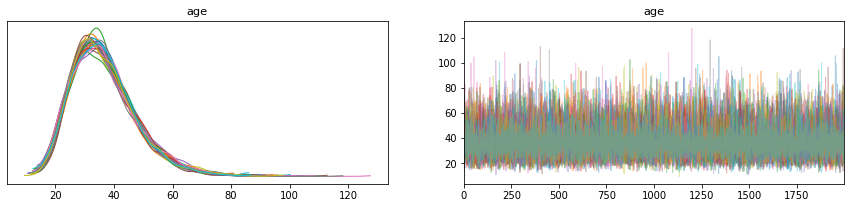

In [5]:
import arviz as az

data = az.from_numpyro(mcmc)
az.plot_trace(data, compact=True, figsize=(15, 3));

## The actual run ... 

In [6]:
mcmc = MCMC(nuts_kernel, num_samples=2000, num_warmup=2000)
rng_key = random.PRNGKey(0)
mcmc.run(rng_key, ages_observed)

posterior_samples = mcmc.get_samples()

sample: 100%|█| 4000/4000 [00:02<00:00, 1743.50it/s, 7 steps of size 5.32e


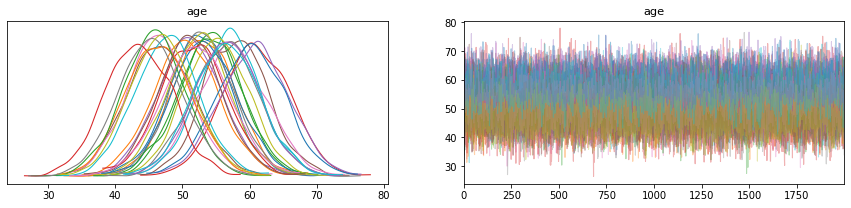

In [7]:
data = az.from_numpyro(mcmc)
az.plot_trace(data, compact=True, figsize=(15, 3));

You can see that we have noisy estimates of age for all 30 people.  Here comes the clever bit - we add more3 information.  We are told that the room of 30 people is actually a University reunion get together.  Hence we now know that all the prople in the room should be of a similar age. But we do not know that that age should be.  So we make a new model with a hyperprior: 

$${ \rm mean \, age} \sim \log \mathcal{N}(\log 35, 0.3)$$

A prior: 

$$ages \sim \mathcal{N}({ \rm mean \, age}, 1.0)$$

and likelihood for each person:

$$age_i \sim \mathcal{N}(ages_i, 5.0, {\rm obs}= {\rm obs}_i)$$

In [8]:
def HBmodel(observed_ages=[]):
    mean_age = numpyro.sample('mean_age', dist.LogNormal(np.log(35), 0.3))
    
    with numpyro.plate('plate_i', n_people):
        age = numpyro.sample('age', dist.Normal(mean_age, 1.0))
        
    if len(observed_ages) > 1:
        with numpyro.plate('data', n_people):
            numpyro.sample('obs', dist.Normal(age, 5.0), obs=observed_ages)

In [9]:
nuts_kernel = NUTS(HBmodel)

hbm_mcmc = MCMC(nuts_kernel, num_samples=4000, num_warmup=4000)
rng_key = random.PRNGKey(0)
hbm_mcmc.run(rng_key, ages_observed)

posterior_samples = hbm_mcmc.get_samples()

sample: 100%|█| 8000/8000 [00:03<00:00, 2194.58it/s, 15 steps of size 1.90


In [10]:
hbm_mcmc.print_summary()


                mean       std    median      5.0%     95.0%     n_eff     r_hat
    age[0]     55.14      1.28     55.13     53.03     57.21    447.56      1.00
    age[1]     55.20      1.30     55.19     53.08     57.31    431.48      1.00
    age[2]     55.21      1.30     55.21     53.13     57.38    477.76      1.00
    age[3]     55.50      1.31     55.51     53.35     57.70    472.25      1.00
    age[4]     55.09      1.29     55.05     53.00     57.13    444.83      1.00
    age[5]     55.37      1.30     55.40     53.25     57.56    441.70      1.00
    age[6]     55.36      1.31     55.35     53.23     57.51    462.89      1.00
    age[7]     55.18      1.30     55.18     52.96     57.17    447.09      1.00
    age[8]     55.14      1.29     55.15     52.90     57.10    420.88      1.00
    age[9]     55.33      1.30     55.31     53.22     57.49    432.03      1.00
   age[10]     55.19      1.30     55.17     53.02     57.21    454.95      1.00
   age[11]     55.07      1

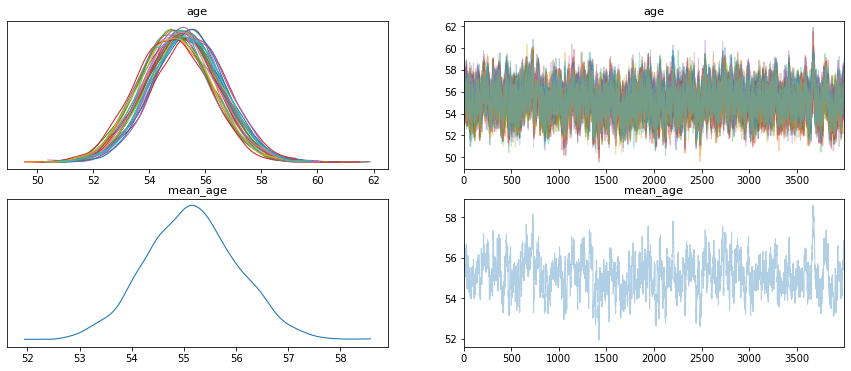

In [11]:
hbm_data = az.from_numpyro(hbm_mcmc)
az.plot_trace(hbm_data, compact=True, figsize=(15, 6));

## An even better HBM model (computationally)

In [12]:
def HBmodel2(observed_ages=[]):
    mean_age = numpyro.sample('mean_age', dist.LogNormal(np.log(35), 0.3))
    
    with numpyro.plate('plate_i', n_people):
        age_ = numpyro.sample('age_', dist.Normal(0, 1.0))
        age = numpyro.deterministic('age', mean_age + age_)
        
    if len(observed_ages) > 1:
        with numpyro.plate('data', n_people):
            numpyro.sample('obs', dist.Normal(age, 5.0), obs=observed_ages)

In [13]:
nuts_kernel = NUTS(HBmodel2)

hbm_mcmc2 = MCMC(nuts_kernel, num_samples=2000, num_warmup=2000)
rng_key = random.PRNGKey(0)
hbm_mcmc2.run(rng_key, ages_observed)

posterior_samples = hbm_mcmc2.get_samples()

sample: 100%|█| 4000/4000 [00:02<00:00, 1349.81it/s, 7 steps of size 6.18e


In [14]:
hbm_mcmc2.print_summary()


                mean       std    median      5.0%     95.0%     n_eff     r_hat
   age_[0]     -0.01      0.99     -0.00     -1.64      1.58   5208.48      1.00
   age_[1]      0.03      0.96      0.04     -1.63      1.49   4807.39      1.00
   age_[2]      0.08      1.01      0.10     -1.59      1.67   5081.38      1.00
   age_[3]      0.33      0.99      0.31     -1.45      1.80   5218.47      1.00
   age_[4]     -0.04      0.94     -0.06     -1.52      1.57   5350.91      1.00
   age_[5]      0.21      0.96      0.21     -1.55      1.65   6521.35      1.00
   age_[6]      0.22      0.95      0.22     -1.37      1.68   5195.65      1.00
   age_[7]      0.03      1.00      0.03     -1.69      1.55   5588.44      1.00
   age_[8]     -0.01      0.95     -0.01     -1.59      1.54   5035.04      1.00
   age_[9]      0.18      0.98      0.19     -1.38      1.78   5285.34      1.00
  age_[10]      0.02      1.01      0.01     -1.49      1.81   5007.07      1.00
  age_[11]     -0.09      0

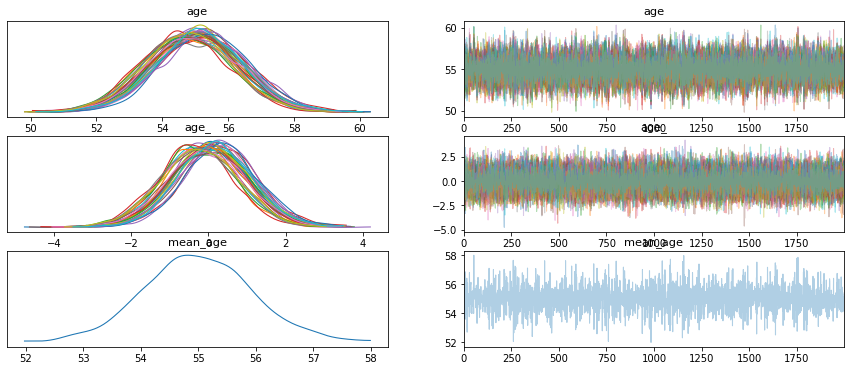

In [15]:
hbm_data2 = az.from_numpyro(hbm_mcmc2)
az.plot_trace(hbm_data2, compact=True, figsize=(15, 6));

Notice how the number of effective samples (n_eff) is much higher for the second HBM model even though we ran it for less iterations. 